<a href="https://colab.research.google.com/github/PederRonning/SOK3022/blob/main/Inflation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [298]:
import pandas as pd

# Load CPI index (2015=100), filter out annual averages
cpi = pd.read_csv('08981_20250513-092551.csv', sep=';', skiprows=2, encoding='latin-1')
cpi = cpi[cpi['måned'] != 'Årsgjennomsnitt']  # drop yearly average rows
# Map month names to month number and construct date index
month_map = {"Januar":1,"Februar":2,"Mars":3,"April":4,"Mai":5,"Juni":6,
             "Juli":7,"August":8,"September":9,"Oktober":10,"November":11,"Desember":12}
cpi['month'] = cpi['måned'].map(month_map)
cpi['date'] = pd.to_datetime(cpi['år'].astype(str) + '-' + cpi['month'].astype(str) + '-01')
cpi = cpi[cpi['Konsumprisindeks (2015=100)'] != '.']  # remove missing values
cpi['CPI_index'] = pd.to_numeric(cpi['Konsumprisindeks (2015=100)'])
cpi.set_index('date', inplace=True)
cpi = cpi.sort_index()

# Load GDP (annual) and wages (annual)
gdp = pd.read_csv('09842_20250513-092607.csv', sep=';', skiprows=2, encoding='latin-1')
gdp = gdp.rename(columns={"Bruttonasjonalprodukt": "GDP"})
gdp['GDP'] = pd.to_numeric(gdp['GDP'])
gdp.index = pd.to_datetime(gdp['år'], format='%Y') + pd.offsets.YearEnd(0)  # use Dec 31 of each year as index
gdp = gdp['GDP']

wages = pd.read_csv('09174_20250513-092734.csv', sep=';', skiprows=2, encoding='latin-1')
wages = wages[wages['næring'] == 'Totalt for næringer'].rename(columns={"Lønn (mill. kr)": "Wages"})
wages['Wages'] = pd.to_numeric(wages['Wages'])
wages.index = pd.to_datetime(wages['år'], format='%Y') + pd.offsets.YearEnd(0)
wages = wages['Wages']

# Load unemployment (employment rate % of population 25–74, monthly)
#labor = pd.read_csv('13760_20250513-092852.csv', sep=';', skiprows=2, encoding='latin-1')
#labor = labor[(labor['kjønn']=='Begge kjønn') & (labor['alder']=='25-74 år') & (labor['type justering']=='Trend')]
#labor['date'] = pd.to_datetime(labor['måned'].str.replace('M', '-')) + pd.offsets.MonthBegin(0)
#labor = labor[labor['Sysselsatte i prosent av befolkningen'] != '..']  # drop missing
#labor['emp_pct'] = pd.to_numeric(labor['Sysselsatte i prosent av befolkningen'])
#labor.set_index('date', inplace=True)
#labor = labor.sort_index()

#labor = pd.read_csv('08518_20250513-135649.csv', sep=';', skiprows=2, encoding='latin-1')
#labor = labor[(labor['kjønn']=='Begge kjønn') & (labor['alder']=='25-74 år') & (labor['type justering']=='Trend')]
#labor['date'] = pd.to_datetime(labor['måned'].str.replace('M', '-')) + pd.offsets.MonthBegin(0)
#labor = labor[labor['Sysselsatte i prosent av befolkningen'] != '..']  # drop missing
#labor['emp_pct'] = pd.to_numeric(labor['Sysselsatte i prosent av befolkningen'])
#labor.set_index('date', inplace=True)
#labor = labor.sort_index()

labor = pd.read_csv('08518_20250513-135649.csv', sep=';', skiprows=2, encoding='latin-1')
#Keep only the time identifier ('kvartal')
labor = labor[['kvartal', 'Arbeidsledige (prosent)']]
labor.columns = ['time', 'Unemp_rate']


labor['time'] = labor['time'].str.replace('K', 'Q')
#    Create a PeriodIndex at quarterly frequency and convert to timestamp at end of quarter
labor['time'] = pd.PeriodIndex(labor['time'], freq='Q').to_timestamp(how='end')

# 5. Set the 'time' column as the index of the DataFrame
labor.set_index('time', inplace=True)
#    Normalize index to midnight to avoid fractional times
labor.index = labor.index.normalize()

# 6. Resample to monthly frequency and interpolate missing values linearly
labor_m = labor.resample('ME').interpolate(method='linear')

# 7. Ensure result is a pandas Series named 'Unemp_rate'
labor_m = labor_m['Unemp_rate']
labor_m.name = 'Unemp_rate'

# Load oil price (assume monthly Brent price series fetched or provided)
oil = pd.read_csv('12462_20250513-123041.csv', sep=';', skiprows=2, encoding='latin-1')
# 2000M01  →  year = 2000, literal 'M', month = 01
oil['date'] = (
    pd.to_datetime(oil['måned'], format='%YM%m')      # parse to 2000-01-01
    + pd.offsets.MonthEnd(0))
oil = oil.rename(columns={"Produsentprisindeks (2021=100)": "Price"})
oil['Price'] = pd.to_numeric(oil['Price'])
oil = oil.set_index('date').sort_index()

In [299]:
labor_m.describe()

,Unemp_rate
count,637.000000
mean,3.489953
std,1.229051
min,1.300000
25%,2.533333
50%,3.533333
75%,4.400000
max,6.400000


In [300]:
url = 'https://data.norges-bank.no/api/data/IR/A.KPRA.SD.?format=csv&startPeriod=1995-05-12&endPeriod=2025-05-12&locale=no&bom=include'

policy_rate = pd.read_csv(url,
    sep=';',
    parse_dates=['TIME_PERIOD'],
    decimal='.' )
policy_rate = policy_rate.rename(columns={"TIME_PERIOD": "date",
                        "OBS_VALUE":   "rate"})
policy_rate.set_index("date", inplace=True)


# keep only date and ploicy_rate

policy_rate = policy_rate[["rate"]]

# make policy_rate numeric, swap , with .

policy_rate['rate'] = policy_rate['rate'].str.replace(',', '.')
policy_rate['rate'] = pd.to_numeric(policy_rate['rate'])

#policy_rate.index = policy_rate.index.year

#policy_rate = oil.set_index('date').sort_index()
print(policy_rate.head())

            rate
date            
1996-01-01  4.48
1997-01-01  3.38
1998-01-01  5.51
1999-01-01  6.35
2000-01-01  6.22


In [301]:
# Resample GDP and wages to monthly frequency via linear interpolation
gdp_monthly = gdp.resample('ME').interpolate(method='linear')
wages_monthly = wages.resample('ME').interpolate(method='linear')

In [302]:
# gdp_monthly in percentage growth
gdp_monthly = gdp_monthly.pct_change() * 100
wages_monthly = wages_monthly.pct_change() * 100

In [303]:
# Resample GDP and wages to monthly frequency via linear interpolation
#gdp_monthly = gdp.resample('ME').interpolate(method='linear')
#wages_monthly = wages.resample('ME').interpolate(method='linear')

# Calculate unemployment rate (%) as 100 - employment_rate (25–74) for each month
#unemp_rate = 100 - labor['emp_pct']

# Assemble a DataFrame of all variables at monthly frequency
df = pd.DataFrame({
    'CPI_index': cpi['CPI_index'],
    'GDP': gdp_monthly,
    'Wages': wages_monthly,
    'Unemp_rate': labor_m,
    'Oil_price': oil['Price'],
    'Policy_rate': policy_rate['rate'], # assume oil DataFrame with 'Price'
}).ffill()  # forward-fill any starting NaNs if needed

In [304]:
df = df[df.index > '2000-01-01']

In [305]:
df

,CPI_index,GDP,Wages,Unemp_rate,Oil_price,Policy_rate
2000-01-31,74.5,1.532500,0.437676,3.433333,17.2,6.22
2000-02-01,74.8,1.532500,0.437676,3.433333,17.2,6.22
2000-02-29,74.8,1.509369,0.435768,3.666667,18.9,6.22
2000-03-01,74.9,1.509369,0.435768,3.666667,18.9,6.22
2000-03-31,74.9,1.486926,0.433878,3.900000,19.3,6.22
...,...,...,...,...,...,...
2025-02-28,137.0,0.076706,0.459104,4.000000,136.3,4.50
2025-03-01,136.1,0.076706,0.459104,4.000000,136.3,4.50
2025-03-31,136.1,0.076706,0.459104,4.100000,117.0,4.50
2025-04-01,137.0,0.076706,0.459104,4.100000,117.0,4.50


In [306]:
# Compute monthly percent changes for all series
df_pct = df
# Drop the first month (no previous month to compare)
df_pct = df_pct.dropna(subset=['CPI_index'])

# Define the target (inflation) and predictor variables
df_pct.rename(columns={'CPI_index': 'Inflation'}, inplace=True)
y = df_pct['Inflation']#.iloc[1:]          # prosentvis cpi, må ta bort 1 for lik lengde på x og y
#X = df_pct[['GDP','Wages','Unemp_rate','Policy_rate']]
X = df_pct[['GDP','Wages','Unemp_rate','Oil_price', 'Policy_rate']].dropna()

In [307]:
# Compute monthly percent changes for all series
#df_pct = df
# Drop the first month (no previous month to compare)
#df_pct = df_pct.dropna(subset=['CPI_index'])

# Define the target (inflation) and predictor variables
#df_pct.rename(columns={'CPI_index': 'Inflation'}, inplace=True)
#df_pct['Infl_lag1'] = df_pct['Inflation'].shift(1).dropna()
#y = df_pct['Inflation'].iloc[1:]          # prosentvis cpi, må ta bort 1 for lik lengde på x og y
#X = df_pct[['GDP','Wages','Unemp_rate','Policy_rate']]
#X = df_pct[['Infl_lag1','GDP','Wages','Unemp_rate','Oil_price', 'Policy_rate']].dropna()

In [308]:
df_pct = df_pct[df_pct.index > '1996-01-01']
df_pct

,Inflation,GDP,Wages,Unemp_rate,Oil_price,Policy_rate
2000-01-31,74.5,1.532500,0.437676,3.433333,17.2,6.22
2000-02-01,74.8,1.532500,0.437676,3.433333,17.2,6.22
2000-02-29,74.8,1.509369,0.435768,3.666667,18.9,6.22
2000-03-01,74.9,1.509369,0.435768,3.666667,18.9,6.22
2000-03-31,74.9,1.486926,0.433878,3.900000,19.3,6.22
...,...,...,...,...,...,...
2025-02-28,137.0,0.076706,0.459104,4.000000,136.3,4.50
2025-03-01,136.1,0.076706,0.459104,4.000000,136.3,4.50
2025-03-31,136.1,0.076706,0.459104,4.100000,117.0,4.50
2025-04-01,137.0,0.076706,0.459104,4.100000,117.0,4.50


In [309]:
import statsmodels.api as sm
# X and y are the same DataFrame / Series you used before
X_const = sm.add_constant(X)         # adds an intercept term
ols_model = sm.OLS(y, X_const).fit()  # fit ordinary least squares

print(ols_model.summary())            # full table: coef, std err, t, P>|t|, etc.

                            OLS Regression Results                            
Dep. Variable:              Inflation   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     445.2
Date:                Tue, 13 May 2025   Prob (F-statistic):          2.29e-199
Time:                        14:56:41   Log-Likelihood:                -2097.8
No. Observations:                 607   AIC:                             4208.
Df Residuals:                     601   BIC:                             4234.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          45.9663      3.568     12.881      

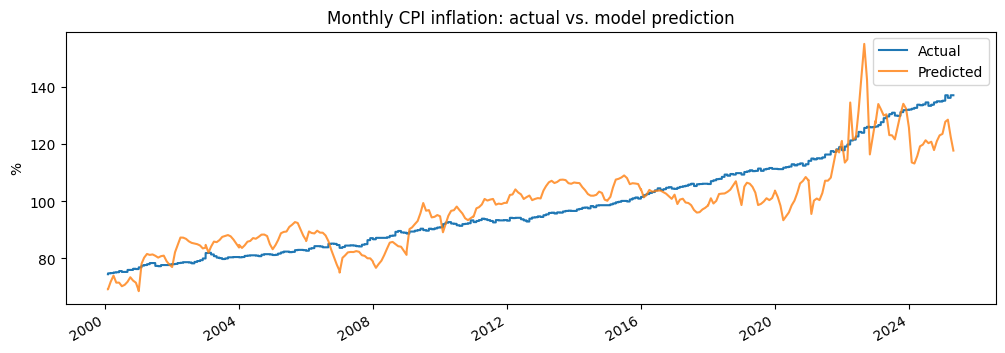

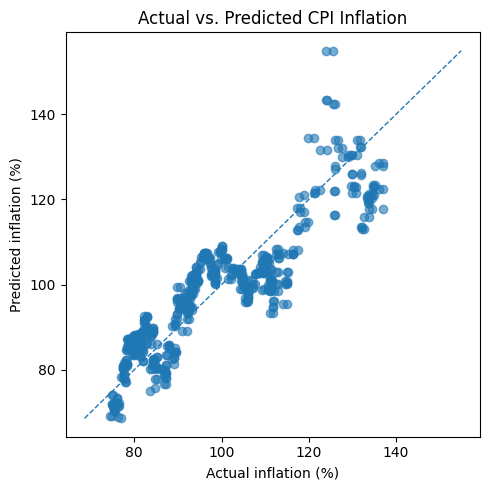

In [310]:
import matplotlib.pyplot as plt

y_pred = ols_model.predict(X_const)        # pandas Series, same index as y
# If you used scikit-learn:
# y_pred = pd.Series(model.predict(X), index=y.index, name='Predicted')

# --- 2. Plot: actual vs. predicted over time ------------------------------
ax = y.plot(label='Actual', figsize=(12, 4))
y_pred.plot(ax=ax, label='Predicted', alpha=0.8)
ax.set_title('Monthly CPI inflation: actual vs. model prediction')
ax.set_ylabel('%')
ax.legend()
plt.show()

# --- 3. Plot: scatter with 45-degree line ---------------------------------
plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, alpha=0.6)
lim = [min(y.min(), y_pred.min()), max(y.max(), y_pred.max())]
plt.plot(lim, lim, '--', lw=1)
plt.xlabel('Actual inflation (%)')
plt.ylabel('Predicted inflation (%)')
plt.title('Actual vs. Predicted CPI Inflation')
plt.tight_layout()
plt.show()

## Med lagged inflation

In [312]:
# Compute monthly percent changes for all series
df_pct_t = df
# Drop the first month (no previous month to compare)
df_pct_t = df_pct_t.dropna(subset=['CPI_index'])

# Define the target (inflation) and predictor variables
df_pct_t.rename(columns={'CPI_index': 'Inflation'}, inplace=True)
df_pct_t['Infl_lag1'] = df_pct_t['Inflation'].shift(1).dropna()
y_t = df_pct_t['Inflation'].iloc[1:]
X_t = df_pct_t[['Infl_lag1','GDP','Wages','Unemp_rate','Oil_price', 'Policy_rate']].dropna()

In [313]:
X_const_t = sm.add_constant(X_t)         # adds an intercept term
ols_model_t = sm.OLS(y_t, X_const_t).fit()  # fit ordinary least squares

print(ols_model_t.summary())

                            OLS Regression Results                            
Dep. Variable:              Inflation   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.195e+05
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        14:59:24   Log-Likelihood:                -231.15
No. Observations:                 606   AIC:                             476.3
Df Residuals:                     599   BIC:                             507.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1333      0.187     -0.714      